In [1]:
!nvidia-smi

Tue May 27 19:02:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [5]:
ieee_fraud_detection_path = kagglehub.competition_download('ieee-fraud-detection')

print('Data source import complete.')
print(ieee_fraud_detection_path)

100%|██████████| 118M/118M [00:06<00:00, 18.1MB/s]

Extracting files...


Data source import complete.
/root/.cache/kagglehub/competitions/ieee-fraud-detection


In [6]:
!ls -la /root/.cache/kagglehub/competitions/ieee-fraud-detection

total 1323220
drwxr-xr-x 2 root root      4096 May 27 19:03 .
drwxr-xr-x 3 root root      4096 May 27 19:03 ..
-rw-r--r-- 1 root root   6080314 May 27 19:03 sample_submission.csv
-rw-r--r-- 1 root root  25797161 May 27 19:03 test_identity.csv
-rw-r--r-- 1 root root 613194934 May 27 19:03 test_transaction.csv
-rw-r--r-- 1 root root  26529680 May 27 19:03 train_identity.csv
-rw-r--r-- 1 root root 683351067 May 27 19:03 train_transaction.csv


In [7]:
KAGGLE_CACHE_PATH = '/root/.cache/kagglehub/competitions/ieee-fraud-detection/'

# Predicting Online Transaction Fraud with XGBoost

## A Comprehensive Pipeline for the IEEE-CIS Dataset

### Introduction

Detecting fraudulent online transactions is a critical challenge in digital commerce. This document outlines a machine learning pipeline utilizing XGBoost to predict fraud probability on the IEEE-CIS Fraud Detection dataset.


The approach focuses on robust feature engineering from complex transactional and identity data, followed by model training with XGBoost. Key steps include data loading and preprocessing, creation of categorical encodings, aggregated statistics, and interaction features. The model is trained using GroupKFold cross-validation to account for temporal data characteristics. The resulting pipeline aims for high-precision fraud detection, with an emphasis on actionable insights derived from feature importance analysis.

## Setup and Configuration

### Import Libraries

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime # Added for TransactionDT features

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [8]:
import xgboost
print(xgboost.__version__)

2.1.4


### Global Configurations and Paths


In [9]:
# --- Define Data Types for Memory Optimization ---
dtypes = {
    'TransactionID': 'int32',
    'isFraud': 'int8', # Target variable
    'TransactionDT': 'int32',
    'TransactionAmt': 'float32',
    'ProductCD': 'object',
    'card1': 'int16', # Changed to int16 as card1 values are usually within this range
    'card2': 'float32', # Kept as float32 to handle NaNs and specific values
    'card3': 'float32',
    'card4': 'object',
    'card5': 'float32',
    'card6': 'object',
    'addr1': 'float32',
    'addr2': 'float32',
    'P_emaildomain': 'object',
    'R_emaildomain': 'object',
}

# V columns
for i in range(1, 340):
    dtypes[f'V{i}'] = 'float32'

# C columns
for i in range(1, 15):
    dtypes[f'C{i}'] = 'float32'

# D columns
for i in range(1, 16):
    dtypes[f'D{i}'] = 'float32' # Dtype for D columns, can be float32

# M columns
for i in range(1, 10):
    dtypes[f'M{i}'] = 'object'

# Identity columns (id_01 to id_38)
# Based on common knowledge of the dataset:
# id_12 to id_38 are often categorical, others float.
# Adjust if your specific version of identity files differs.
for i in range(1, 39):
    col_name = f'id_{i:02d}'
    if i in [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]:
        dtypes[col_name] = 'object'
    else:
        dtypes[col_name] = 'float32'
# Device info columns from identity table
dtypes['DeviceInfo'] = 'object'
dtypes['DeviceType'] = 'object'


# --- Column Definitions (for potential use in usecols, though not strictly used this way in original load) ---
# The original `cols` list seems to be an *intended* list of features
# but it's not directly used for loading. It's effectively superseded by `self.features`
# which is built dynamically in `prepare_features`.
# We'll keep the definition for completeness if it was intended for some other purpose or future use.
cols_definition = [
    'TransactionID', 'isFraud', # isFraud included if loading with target
    'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
    'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'
]
cols_definition.extend([f'V{i}' for i in range(1, 340)])
cols_definition.extend([f'C{i}' for i in range(1, 15)])
cols_definition.extend([f'D{i}' for i in range(1, 16)])
cols_definition.extend([f'M{i}' for i in range(1, 10)])
# Add id columns if they are part of the intended feature set
cols_definition.extend([f'id_{i:02d}' for i in range(1, 39)])
cols_definition.extend(['DeviceInfo', 'DeviceType'])


# --- Configuration for the run ---
USE_GPU = True # Set to False if GPU is not available or not desired

# Define file paths (ADJUST THESE TO YOUR ENVIRONMENT)
TRANSACTION_TRAIN_PATH = f'{KAGGLE_CACHE_PATH}train_transaction.csv'
IDENTITY_TRAIN_PATH    = f'{KAGGLE_CACHE_PATH}train_identity.csv'
TRANSACTION_TEST_PATH  = f'{KAGGLE_CACHE_PATH}test_transaction.csv'
IDENTITY_TEST_PATH     = f'{KAGGLE_CACHE_PATH}test_identity.csv'
SAMPLE_SUBMISSION_PATH = f'{KAGGLE_CACHE_PATH}sample_submission.csv'
OUTPUT_SUBMISSION_PATH = 'submission.csv' # Will be saved in working directory

print("Configurations and Paths set.")
print(f"Data types defined for {len(dtypes)} columns.")

Configurations and Paths set.
Data types defined for 432 columns.


## Pipeline Class Definition

### `FraudDetectionPipeline` Class

In [10]:
class FraudDetectionPipeline:
    def __init__(self, use_gpu=True):
        self.use_gpu = use_gpu
        self.features = None
        self.model = None
        self.all_models = []
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.oof = None
        self.preds = None
        self.feature_importances_ = None
        self.mean_feature_importances_ = None

        self.xgb_params = {
            'max_depth': 12, # Original: 12
            'learning_rate': 0.015, # Original: 0.02, slightly lower
            'n_estimators': 3000, # Original: 2000, increased
            'subsample': 0.8,
            'colsample_bytree': 0.4,
            'min_child_weight': 3, # Added for regularization
            'gamma': 0.1,          # Added for regularization
            'missing': -1,
            'eval_metric': 'auc',
            'tree_method': 'hist',
            'random_state': 42,
        }

        if self.use_gpu:
            print("Attempting to configure for GPU usage.")
            try:
                xgb.XGBClassifier(tree_method='hist', device='cuda').get_params()
                self.xgb_params['device'] = 'cuda'
                print("GPU available and configured for XGBoost (device='cuda').")
            except Exception as e:
                print(f"GPU not available or XGBoost not compiled with GPU support: {e}")
                print("Falling back to CPU.")
                self.xgb_params['device'] = 'cpu'
                self.use_gpu = False
        else:
            self.xgb_params['device'] = 'cpu'
            print("Using CPU as per configuration.")

    def load_data(self, transaction_train_path, identity_train_path,
                 transaction_test_path, identity_test_path, dtypes_map, cols_to_load_list=None):
        print("Loading data...")

        df_train_trans = pd.read_csv(transaction_train_path, dtype=dtypes_map, usecols=lambda c: c in dtypes_map or c == 'isFraud')
        df_train_id = pd.read_csv(identity_train_path, dtype=dtypes_map, usecols=lambda c: c in dtypes_map)

        self.y_train = df_train_trans['isFraud'].copy().astype('int8')
        self.X_train = df_train_trans.drop('isFraud', axis=1)
        del df_train_trans

        self.X_train.set_index('TransactionID', inplace=True)
        df_train_id.set_index('TransactionID', inplace=True)
        self.X_train = self.X_train.merge(df_train_id, how='left', left_index=True, right_index=True)
        del df_train_id

        # Load test data
        self.X_test = pd.read_csv(transaction_test_path, dtype=dtypes_map, usecols=lambda c: c in dtypes_map)

        # --- Improved loading for df_test_id ---
        df_test_id_raw = pd.read_csv(identity_test_path) # Load all columns initially

        rename_map_test_id = {}
        expected_id_cols_from_dtypes = {col for col in dtypes_map if col.startswith('id_') or col in ['DeviceInfo', 'DeviceType']}

        for raw_col_name in df_test_id_raw.columns:
            if 'id-' in raw_col_name:
                potential_train_name = raw_col_name.replace('id-', 'id_')
                if potential_train_name in expected_id_cols_from_dtypes:
                    rename_map_test_id[raw_col_name] = potential_train_name

        if rename_map_test_id:
            df_test_id_raw.rename(columns=rename_map_test_id, inplace=True)
            print(f"Renamed test identity columns (raw load): {rename_map_test_id}")

        # Create df_test_id by selecting relevant columns and applying dtypes
        df_test_id = pd.DataFrame()
        # Ensure TransactionID is handled first for index setting
        if 'TransactionID' in df_test_id_raw.columns:
             df_test_id['TransactionID'] = df_test_id_raw['TransactionID'].astype(dtypes_map.get('TransactionID', 'int32'))

        for col in dtypes_map: # Iterate through dtypes_map to ensure all expected columns are considered
            if col in df_test_id_raw.columns and col not in ['isFraud', 'TransactionID']: # Exclude target and already handled ID
                try:
                    df_test_id[col] = df_test_id_raw[col].astype(dtypes_map[col])
                except Exception as e:
                    # print(f"Warning: Could not astype column {col} in df_test_id to {dtypes_map[col]}. Error: {e}. Trying with pd.to_numeric or keeping as object.")
                    if pd.api.types.is_numeric_dtype(dtypes_map.get(col)):
                        df_test_id[col] = pd.to_numeric(df_test_id_raw[col], errors='coerce').astype(dtypes_map[col])
                    else:
                        df_test_id[col] = df_test_id_raw[col].astype('object') # Fallback for object types
        # --- End of improved loading for df_test_id ---

        self.X_test.set_index('TransactionID', inplace=True)
        if 'TransactionID' in df_test_id.columns:
             df_test_id.set_index('TransactionID', inplace=True)
        else:
            print("CRITICAL WARNING: TransactionID not found in processed df_test_id. Merge might fail or be incorrect.")


        self.X_test = self.X_test.merge(df_test_id, how='left', left_index=True, right_index=True)
        del df_test_id, df_test_id_raw
        gc.collect()

        print(f'Train shape: {self.X_train.shape}, Test shape: {self.X_test.shape}')
        print(f'Target y_train shape: {self.y_train.shape}')
        if self.X_train.index.name != 'TransactionID' or self.X_test.index.name != 'TransactionID':
            print("Warning: Index name is not TransactionID after merge.")


    def frequency_encode(self, columns_to_encode):
        print("\nStarting Frequency Encoding...")
        for col in columns_to_encode:
            if col in self.X_train.columns and col in self.X_test.columns:
                print(f'Frequency encoding: {col}')
                combined_series = pd.concat([self.X_train[col], self.X_test[col]], ignore_index=True)
                vc = combined_series.value_counts(dropna=False, normalize=True).to_dict()
                new_col_name = f'{col}_FE'
                self.X_train[new_col_name] = self.X_train[col].map(vc).astype('float32')
                self.X_test[new_col_name] = self.X_test[col].map(vc).astype('float32')
            else:
                print(f"Warning: Column {col} not found for frequency encoding. Skipping.")
        gc.collect()

    def label_encode(self, column_to_encode):
        if column_to_encode in self.X_train.columns and column_to_encode in self.X_test.columns:
            print(f'Label encoding: {column_to_encode}')
            df_comb = pd.concat([self.X_train[column_to_encode], self.X_test[column_to_encode]], axis=0)
            factorized_values, _ = pd.factorize(df_comb, sort=True)
            max_val = factorized_values.max()
            dtype = 'int32'
            if max_val < np.iinfo(np.int8).max and factorized_values.min() >= np.iinfo(np.int8).min : dtype = 'int8'
            elif max_val < np.iinfo(np.int16).max and factorized_values.min() >= np.iinfo(np.int16).min: dtype = 'int16'

            self.X_train[column_to_encode] = factorized_values[:len(self.X_train)].astype(dtype)
            self.X_test[column_to_encode] = factorized_values[len(self.X_train):].astype(dtype)
        else:
            print(f"Warning: Column {column_to_encode} not found for label encoding. Skipping.")
        gc.collect()

    def create_aggregations(self, main_agg_columns, uid_columns, agg_types=['mean', 'std']):
        print("\nStarting Aggregation Feature Creation...")
        for main_col in main_agg_columns:
            for uid_col in uid_columns:
                # Ensure uid_col is numeric if it was an object (e.g. P_emaildomain after LE)
                if uid_col in self.X_train.columns and not pd.api.types.is_numeric_dtype(self.X_train[uid_col]):
                    print(f"Warning: UID column {uid_col} for aggregation is not numeric. Skipping aggregation {main_col}_by_{uid_col}.")
                    continue

                if uid_col in self.X_train.columns and uid_col in self.X_test.columns and \
                   main_col in self.X_train.columns and main_col in self.X_test.columns:
                    for agg_type in agg_types:
                        new_col_name = f'{main_col}_by_{uid_col}_{agg_type}'
                        print(f'Creating aggregation: {new_col_name}')
                        temp_df = pd.concat([self.X_train[[uid_col, main_col]], self.X_test[[uid_col, main_col]]], ignore_index=True)

                        # Ensure main_col is numeric for aggregation
                        if not pd.api.types.is_numeric_dtype(temp_df[main_col]):
                            temp_df[main_col] = pd.to_numeric(temp_df[main_col], errors='coerce')


                        agg_map = temp_df.groupby(uid_col)[main_col].agg(agg_type)
                        self.X_train[new_col_name] = self.X_train[uid_col].map(agg_map).astype('float32')
                        self.X_test[new_col_name] = self.X_test[uid_col].map(agg_map).astype('float32')
                        # .fillna(-1) will be done globally later for all features
                else:
                    print(f"Warning: Columns {main_col} or {uid_col} not found for aggregation. Skipping this pair.")
        gc.collect()

    def create_combined_features(self, feature_pairs):
        print("\nStarting Combined Feature Creation...")
        for col1, col2 in feature_pairs:
            if col1 in self.X_train.columns and col1 in self.X_test.columns and \
               col2 in self.X_train.columns and col2 in self.X_test.columns:
                new_col_name = f'{col1}__{col2}'
                print(f'Creating combined feature: {new_col_name}')
                self.X_train[new_col_name] = (self.X_train[col1].astype(str) + '_' + self.X_train[col2].astype(str))
                self.X_test[new_col_name] = (self.X_test[col1].astype(str) + '_' + self.X_test[col2].astype(str))
                self.label_encode(new_col_name)
            else:
                print(f"Warning: Columns {col1} or {col2} not found for combined feature creation. Skipping this pair.")
        gc.collect()

    def prepare_features(self):
        print("\n--- Starting Feature Preparation ---")

        # 1. Create DT_M (Month) for GroupKFold & TransactionDT derived time features
        START_DATE = '2017-12-01'
        startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
        for df in [self.X_train, self.X_test]:
            if 'TransactionDT' in df.columns:
                df['DT_M'] = np.floor(df['TransactionDT'] / (24*60*60*30)).astype(int)
                # Create datetime object to extract time features
                df['Transaction_datetime'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
                df['Transaction_day_of_week'] = df['Transaction_datetime'].dt.dayofweek.astype('int8')
                df['Transaction_hour'] = df['Transaction_datetime'].dt.hour.astype('int8')
                df.drop(columns=['Transaction_datetime'], inplace=True, errors='ignore')
            else: # Ensure DT_M exists even if TransactionDT was missing (e.g. after some processing)
                if 'DT_M' not in df.columns: df['DT_M'] = 0 # Fallback
                if 'Transaction_day_of_week' not in df.columns: df['Transaction_day_of_week'] = 0
                if 'Transaction_hour' not in df.columns: df['Transaction_hour'] = 0


        print("Created DT_M, Transaction_day_of_week, Transaction_hour features.")

        # 1.b. Email domain parsing
        for df in [self.X_train, self.X_test]:
            for col_prefix in ['P', 'R']:
                email_col = f'{col_prefix}_emaildomain'
                if email_col in df.columns:
                    df[f'{email_col}_bin'] = df[email_col].apply(lambda x: str(x).split('.')[0] if pd.notna(x) else 'nan_bin')
                    df[f'{email_col}_suffix'] = df[email_col].apply(lambda x: str(x).split('.')[-1] if pd.notna(x) else 'nan_suffix')
        print("Created P_emaildomain and R_emaildomain bin/suffix features.")

        # 1.c. DeviceInfo parsing (basic)
        for df in [self.X_train, self.X_test]:
            if 'DeviceInfo' in df.columns:
                df['DeviceInfo_vendor'] = df['DeviceInfo'].apply(lambda x: str(x).split()[0] if isinstance(x, str) and x else 'unknown_device')
            else: # Ensure column exists if not in original data for consistency
                df['DeviceInfo_vendor'] = 'unknown_device'

        print("Created DeviceInfo_vendor feature.")

        # 2. Label encode all object/categorical columns
        print("\nLabel encoding object columns...")
        # Important: Select_dtypes AFTER new object columns are created
        object_cols_to_encode = [col for col in self.X_train.select_dtypes(include=['object']).columns
                                 if col in self.X_test.columns and col not in ['DT_M']] # DT_M is already int
        for col in object_cols_to_encode:
            self.label_encode(col)

        # 3. Transaction amount cents feature
        print("Creating 'cents' feature...")
        for df in [self.X_train, self.X_test]:
            if 'TransactionAmt' in df.columns:
                 df['cents'] = (df['TransactionAmt'] - np.floor(df['TransactionAmt'])).astype('float32')
            else: # Ensure column exists
                 df['cents'] = -1.0


        # 4. Basic frequency encoding (include new parsed categoricals if desired)
        fe_cols = ['addr1', 'card1', 'card2', 'card3', 'P_emaildomain',
                   'P_emaildomain_bin', 'P_emaildomain_suffix', 'DeviceInfo_vendor'] # Added new ones
        fe_cols_present = [col for col in fe_cols if col in self.X_train.columns and col in self.X_test.columns]
        if fe_cols_present: self.frequency_encode(fe_cols_present)

        # 5. Combined features
        combined_pairs = [('card1', 'addr1')]
        valid_pairs = [(p1, p2) for p1, p2 in combined_pairs if p1 in self.X_train.columns and p2 in self.X_train.columns]
        if valid_pairs: self.create_combined_features(valid_pairs)

        if 'card1__addr1' in self.X_train.columns and 'P_emaildomain' in self.X_train.columns:
             self.create_combined_features([('card1__addr1', 'P_emaildomain')]) # P_emaildomain is now LE'd
        else:
            print("Skipping 'card1__addr1__P_emaildomain' combination as base features are missing or not numeric.")

        # 6. Frequency encode newly combined features
        fe_combined_cols = ['card1__addr1', 'card1__addr1__P_emaildomain']
        fe_combined_cols_present = [col for col in fe_combined_cols if col in self.X_train.columns and col in self.X_test.columns]
        if fe_combined_cols_present: self.frequency_encode(fe_combined_cols_present)

        # 7. Create aggregations (Expanded)
        agg_main_cols = ['TransactionAmt', 'D1', 'D4', 'D9', 'D11', 'D15'] # Added D1, D4, D15
        agg_uids = ['card1', 'card1__addr1', 'card1__addr1__P_emaildomain', 'addr1', 'P_emaildomain'] # Added addr1, P_emaildomain (LE'd)

        agg_main_cols_present = [col for col in agg_main_cols if col in self.X_train.columns and col in self.X_test.columns]
        agg_uids_present = [col for col in agg_uids if col in self.X_train.columns and col in self.X_test.columns]

        if agg_main_cols_present and agg_uids_present:
            self.create_aggregations(
                main_agg_columns=agg_main_cols_present,
                uid_columns=agg_uids_present,
                agg_types=['mean', 'std', 'nunique'] # Added nunique
            )
        else:
            print("Skipping some aggregations due to missing base columns.")

        # 8. Define final feature list and remove unnecessary columns
        # Review this list. For now, keeping it mostly as is.
        # TransactionDT is definitely removed. Original D9, D11 might be removed if their aggs are better.
        cols_to_remove_orig = (
            ['TransactionDT'] +
            ['D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14'] + # D9, D11 are used in aggs, originals can be removed
            ['C3', 'M5', 'id_08', 'id_33'] +
            # 'card4' is label encoded and might be useful. Let's keep it for now.
            # Removing card4 from removal list.
            ['id_07', 'id_14', 'id_21', 'id_30', 'id_32', 'id_34'] +
            [f'id_{x:02d}' for x in range(22, 28)]
        )
        # Ensure D9, D11 are removed if they were only for aggs and not good as direct features.
        # If D1, D4, D15 are used in aggs, their original forms can also be considered for removal.

        all_train_cols = list(self.X_train.columns)
        all_test_cols = list(self.X_test.columns) # Get all columns currently in X_test

        potential_features = [col for col in all_train_cols if col not in cols_to_remove_orig]

        self.features = []
        for col in potential_features:
            if col == 'DT_M': continue
            if col not in all_test_cols: # Check if column also exists in X_test
                print(f"Info: Feature '{col}' exists in train but not test (or was removed). Removing from final features.")
                continue
            if pd.api.types.is_numeric_dtype(self.X_train[col]):
                self.features.append(col)
            else:
                print(f"Warning: Non-numeric feature '{col}' of type {self.X_train[col].dtype} was about to be included. Explicitly removing.")

        # Ensure X_train and X_test have the same feature columns + DT_M for grouping
        cols_to_keep_train = self.features + (['DT_M'] if 'DT_M' in self.X_train.columns else [])
        cols_to_keep_test = self.features + (['DT_M'] if 'DT_M' in self.X_test.columns else [])

        self.X_train = self.X_train[cols_to_keep_train]
        self.X_test = self.X_test[cols_to_keep_test]

        # Align columns one last time to be absolutely sure
        # This is critical if some features were created in train but not test due to missing base columns
        common_features_final = [f for f in self.features if f in self.X_test.columns]
        self.features = common_features_final

        self.X_train = self.X_train[self.features + (['DT_M'] if 'DT_M' in self.X_train.columns else [])]
        self.X_test = self.X_test[self.features + (['DT_M'] if 'DT_M' in self.X_test.columns else [])]


        # 9. Fill NaNs for all feature columns
        print(f"\nFilling NaNs with -1 for {len(self.features)} features in X_train and X_test...")
        if self.features: # Only fill if features list is not empty
            self.X_train[self.features] = self.X_train[self.features].fillna(-1)
            self.X_test[self.features] = self.X_test[self.features].fillna(-1)

        print(f"Feature preparation complete. Number of features: {len(self.features)}")
        if 'DT_M' not in self.X_train.columns or 'DT_M' not in self.X_test.columns:
             print("CRITICAL WARNING: DT_M column is missing from X_train or X_test after feature prep!")
        gc.collect()

    def get_xgb_params(self):
        return self.xgb_params.copy()

    def train_model(self, n_splits=6, early_stopping_rounds_config=200):
        if self.X_train is None or self.y_train is None or self.features is None or not self.features:
            print("Data not loaded or features not prepared/empty. Cannot train model.")
            return

        print(f"\n--- Starting Model Training with {n_splits} splits ---")
        self.oof = np.zeros(len(self.X_train))
        self.preds = np.zeros(len(self.X_test))
        self.all_models = []

        if 'DT_M' not in self.X_train.columns:
            print("Error: 'DT_M' column for grouping is missing from X_train. Cannot perform GroupKFold.")
            return
        groups = self.X_train['DT_M']

        skf = GroupKFold(n_splits=n_splits)
        fold_feature_importances_list = []

        for i, (train_idx, val_idx) in enumerate(skf.split(self.X_train[self.features], self.y_train, groups=groups)):
            fold_num = i + 1
            print(f'\n----- Training Fold {fold_num}/{n_splits} -----')

            X_fold_train, y_fold_train = self.X_train[self.features].iloc[train_idx], self.y_train.iloc[train_idx]
            X_fold_val, y_fold_val = self.X_train[self.features].iloc[val_idx], self.y_train.iloc[val_idx]

            current_params = self.get_xgb_params() # This gets your base parameters

            # Create the EarlyStopping callback
            early_stop_callback = EarlyStopping(
                rounds=early_stopping_rounds_config,
                metric_name='auc', # Monitor AUC on eval set
                save_best=True     # Model returned will be the best one
            )

            # Add the callback to the parameters for the constructor
            current_params['callbacks'] = [early_stop_callback]

            # Initialize the model WITH the callbacks
            fold_model = xgb.XGBClassifier(**current_params)

            # Now fit the model. The 'callbacks' argument is NOT needed in fit() for newer XGBoost
            fold_model.fit(
                X_fold_train, y_fold_train,
                eval_set=[(X_fold_val, y_fold_val)],
                verbose=100 # Prints evaluation results every 100 rounds
            )

            print(f"Best iteration: {fold_model.best_iteration}")

            val_preds = fold_model.predict_proba(X_fold_val)[:,1]
            self.oof[val_idx] = val_preds

            test_fold_preds = fold_model.predict_proba(self.X_test[self.features])[:,1]
            self.preds += test_fold_preds / n_splits

            self.all_models.append(fold_model)
            self.model = fold_model

            fold_imp_df = pd.DataFrame({'feature': self.features, 'importance': fold_model.feature_importances_, 'fold': fold_num})
            fold_feature_importances_list.append(fold_imp_df)

            print(f"Fold {fold_num} Val AUC: {roc_auc_score(y_fold_val, val_preds):.4f}")
            del X_fold_train, y_fold_train, X_fold_val, y_fold_val
            gc.collect()

        self.feature_importances_ = pd.concat(fold_feature_importances_list, ignore_index=True)
        self.mean_feature_importances_ = self.feature_importances_.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

        cv_score = roc_auc_score(self.y_train, self.oof)
        print(f'\n--- Cross-validation ROC AUC: {cv_score:.4f} ---')

        self.feature_importances_ = pd.concat(fold_feature_importances_list, ignore_index=True)
        self.mean_feature_importances_ = self.feature_importances_.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

        cv_score = roc_auc_score(self.y_train, self.oof)
        print(f'\n--- Cross-validation ROC AUC: {cv_score:.4f} ---')


    def plot_feature_importance(self, top_n=50):
        if self.mean_feature_importances_ is None or self.mean_feature_importances_.empty:
            print("Mean feature importances not available. Train model first.")
            return

        plt.figure(figsize=(12, max(6, top_n // 2))) # Adjusted figure size
        sns.barplot(x="importance", y="feature",
                   data=self.mean_feature_importances_.head(top_n),
                   palette="viridis")
        plt.title(f'Top {top_n} XGBoost Feature Importances (Average over folds)')
        plt.tight_layout()
        plt.show()

    def save_predictions(self, sample_submission_path, output_path, plot_dist=True):
        if self.preds is None:
            print("No predictions available to save.")
            return

        print(f"\nSaving predictions to {output_path}...")
        try:
            submission_df_template = pd.read_csv(sample_submission_path)

            # Create a DataFrame with predictions and TransactionID from X_test
            # X_test index should be TransactionID
            if self.X_test.index.name == 'TransactionID':
                pred_df = pd.DataFrame({'TransactionID': self.X_test.index, 'isFraud': self.preds})
            else: # Fallback if index name is not TransactionID, assuming order matches
                print("Warning: X_test.index.name is not 'TransactionID'. Assuming order matches sample submission.")
                # This case needs careful handling if X_test was reordered.
                # For this pipeline, X_test index is set to TransactionID.
                # If this error occurs, there's an issue in data loading/prep.
                # A robust fallback would require TransactionID to be a column in X_test.
                # However, the pipeline sets it as index.
                # If X_test was reset_index() somewhere, this would be needed:
                # pred_df = pd.DataFrame({'TransactionID': self.X_test['TransactionID'], 'isFraud': self.preds})
                # For now, assume X_test.index is TransactionID as per pipeline design.
                print("Attempting to use X_test.index assuming it's TransactionID values.")
                pred_df = pd.DataFrame({'TransactionID': self.X_test.index, 'isFraud': self.preds})


            # Merge with the submission template to ensure correct order and all TransactionIDs
            submission_df = submission_df_template[['TransactionID']].merge(pred_df, on='TransactionID', how='left')

            if submission_df['isFraud'].isnull().any():
                print(f"Warning: {submission_df['isFraud'].isnull().sum()} TransactionIDs in submission file were not found in test predictions. Filling with 0.")
                submission_df['isFraud'].fillna(0, inplace=True) # Or a neutral value like 0.5 or mean of preds

            submission_df[['TransactionID', 'isFraud']].to_csv(output_path, index=False)
            print(f"Predictions successfully saved to {output_path}")

            if plot_dist:
                plt.figure(figsize=(10, 6))
                sns.histplot(submission_df.isFraud, bins=100, kde=True, color="skyblue") # kde=True
                plt.title('Prediction Distribution on Test Set')
                plt.xlabel('Predicted Fraud Probability')
                plt.ylabel('Density') # Changed for KDE
                plt.grid(axis='y', alpha=0.75)
                plt.show()
        except FileNotFoundError:
            print(f"Error: Sample submission file not found at {sample_submission_path}")
        except Exception as e:
            print(f"An error occurred during saving predictions: {e}")

print("FraudDetectionPipeline class defined with improvements.")

FraudDetectionPipeline class defined with improvements.


## Pipeline Execution

### Initialize Pipeline

In [11]:
pipeline = FraudDetectionPipeline(use_gpu=USE_GPU)

Attempting to configure for GPU usage.
GPU available and configured for XGBoost (device='cuda').


### Load and Inspect Data

In [13]:
# Load data using the global dtypes map
# cols_to_load_list is effectively handled by lambda in read_csv to only use keys in dtypes_map
pipeline.load_data(
    transaction_train_path = TRANSACTION_TRAIN_PATH,
    identity_train_path    = IDENTITY_TRAIN_PATH,
    transaction_test_path  = TRANSACTION_TEST_PATH,
    identity_test_path     = IDENTITY_TEST_PATH,
    dtypes_map=dtypes
)

# Optional: Inspect loaded data
if pipeline.X_train is not None and pipeline.y_train is not None:
    print("\n--- Train Data Sample (First 5 rows) ---")
    print(pipeline.X_train.head())
    print("\n--- Train Data Info (dtypes and memory) ---")
    pipeline.X_train.info(verbose=False, memory_usage='deep')
    print("\n--- Target Variable Distribution (y_train) ---")
    print(pipeline.y_train.value_counts(normalize=True))

if pipeline.X_test is not None:
    print("\n--- Test Data Sample (First 5 rows) ---")
    print(pipeline.X_test.head())
    print("\n--- Test Data Info (dtypes and memory) ---")
    pipeline.X_test.info(verbose=False, memory_usage='deep')

Loading data...
Renamed test identity columns (raw load): {'id-01': 'id_01', 'id-02': 'id_02', 'id-03': 'id_03', 'id-04': 'id_04', 'id-05': 'id_05', 'id-06': 'id_06', 'id-07': 'id_07', 'id-08': 'id_08', 'id-09': 'id_09', 'id-10': 'id_10', 'id-11': 'id_11', 'id-12': 'id_12', 'id-13': 'id_13', 'id-14': 'id_14', 'id-15': 'id_15', 'id-16': 'id_16', 'id-17': 'id_17', 'id-18': 'id_18', 'id-19': 'id_19', 'id-20': 'id_20', 'id-21': 'id_21', 'id-22': 'id_22', 'id-23': 'id_23', 'id-24': 'id_24', 'id-25': 'id_25', 'id-26': 'id_26', 'id-27': 'id_27', 'id-28': 'id_28', 'id-29': 'id_29', 'id-30': 'id_30', 'id-31': 'id_31', 'id-32': 'id_32', 'id-33': 'id_33', 'id-34': 'id_34', 'id-35': 'id_35', 'id-36': 'id_36', 'id-37': 'id_37', 'id-38': 'id_38'}
Train shape: (590540, 430), Test shape: (506691, 430)
Target y_train shape: (590540,)

--- Train Data Sample (First 5 rows) ---
               TransactionDT  TransactionAmt ProductCD  card1  card2  card3  \
TransactionID                                     

### Feature Engineering

In [15]:
if pipeline.X_train is not None: # Check if data is loaded
    pipeline.prepare_features()

    # Optional: Inspect features after preparation
    if pipeline.features:
        print("\n--- Features Post-Preparation (Train - First 5 rows, first 10 features) ---")
        print(pipeline.X_train[pipeline.features].iloc[:, :10].head())
        print(f"\nTotal number of selected features: {len(pipeline.features)}")
        print("\n--- Memory usage after feature engineering (Train) ---")
        # Create a temporary dataframe with only selected features for accurate memory info
        temp_train_features_df = pipeline.X_train[pipeline.features]
        temp_train_features_df.info(verbose=False, memory_usage='deep')
        del temp_train_features_df
        gc.collect()
    else:
        print("Feature list is empty after preparation.")
else:
    print("Data not loaded, skipping feature preparation.")


--- Starting Feature Preparation ---
Created DT_M, Transaction_day_of_week, Transaction_hour features.
Created P_emaildomain and R_emaildomain bin/suffix features.
Created DeviceInfo_vendor feature.

Label encoding object columns...
Label encoding: P_emaildomain_bin
Label encoding: P_emaildomain_suffix
Label encoding: R_emaildomain_bin
Label encoding: R_emaildomain_suffix
Label encoding: DeviceInfo_vendor
Creating 'cents' feature...

Starting Frequency Encoding...
Frequency encoding: addr1
Frequency encoding: card1
Frequency encoding: card2
Frequency encoding: card3
Frequency encoding: P_emaildomain
Frequency encoding: P_emaildomain_bin
Frequency encoding: P_emaildomain_suffix
Frequency encoding: DeviceInfo_vendor

Starting Combined Feature Creation...
Creating combined feature: card1__addr1
Label encoding: card1__addr1

Starting Combined Feature Creation...
Creating combined feature: card1__addr1__P_emaildomain
Label encoding: card1__addr1__P_emaildomain

Starting Frequency Encoding.

### Model Training

In [16]:
if pipeline.X_train is not None and pipeline.features and pipeline.y_train is not None:
    pipeline.train_model(n_splits=6, early_stopping_rounds_config=200)
else:
    print("Data or features not ready, or target is missing. Skipping model training.")


--- Starting Model Training with 6 splits ---

----- Training Fold 1/6 -----
[0]	validation_0-auc:0.81304
[100]	validation_0-auc:0.87406
[200]	validation_0-auc:0.89634
[300]	validation_0-auc:0.90561
[400]	validation_0-auc:0.91109
[500]	validation_0-auc:0.91445
[600]	validation_0-auc:0.91642
[700]	validation_0-auc:0.91769
[800]	validation_0-auc:0.91795
[900]	validation_0-auc:0.91814
[1000]	validation_0-auc:0.91834
[1100]	validation_0-auc:0.91854
[1200]	validation_0-auc:0.91818
[1300]	validation_0-auc:0.91789
[1329]	validation_0-auc:0.91790
Best iteration: 1130
Fold 1 Val AUC: 0.9187

----- Training Fold 2/6 -----
[0]	validation_0-auc:0.83154
[100]	validation_0-auc:0.90378
[200]	validation_0-auc:0.92657
[300]	validation_0-auc:0.93656
[400]	validation_0-auc:0.94105
[500]	validation_0-auc:0.94283
[600]	validation_0-auc:0.94353
[700]	validation_0-auc:0.94377
[800]	validation_0-auc:0.94379
[900]	validation_0-auc:0.94379
[1000]	validation_0-auc:0.94354
[1093]	validation_0-auc:0.94335
Best it

### Model Evaluation and Analysis

#### Plot Feature Importance

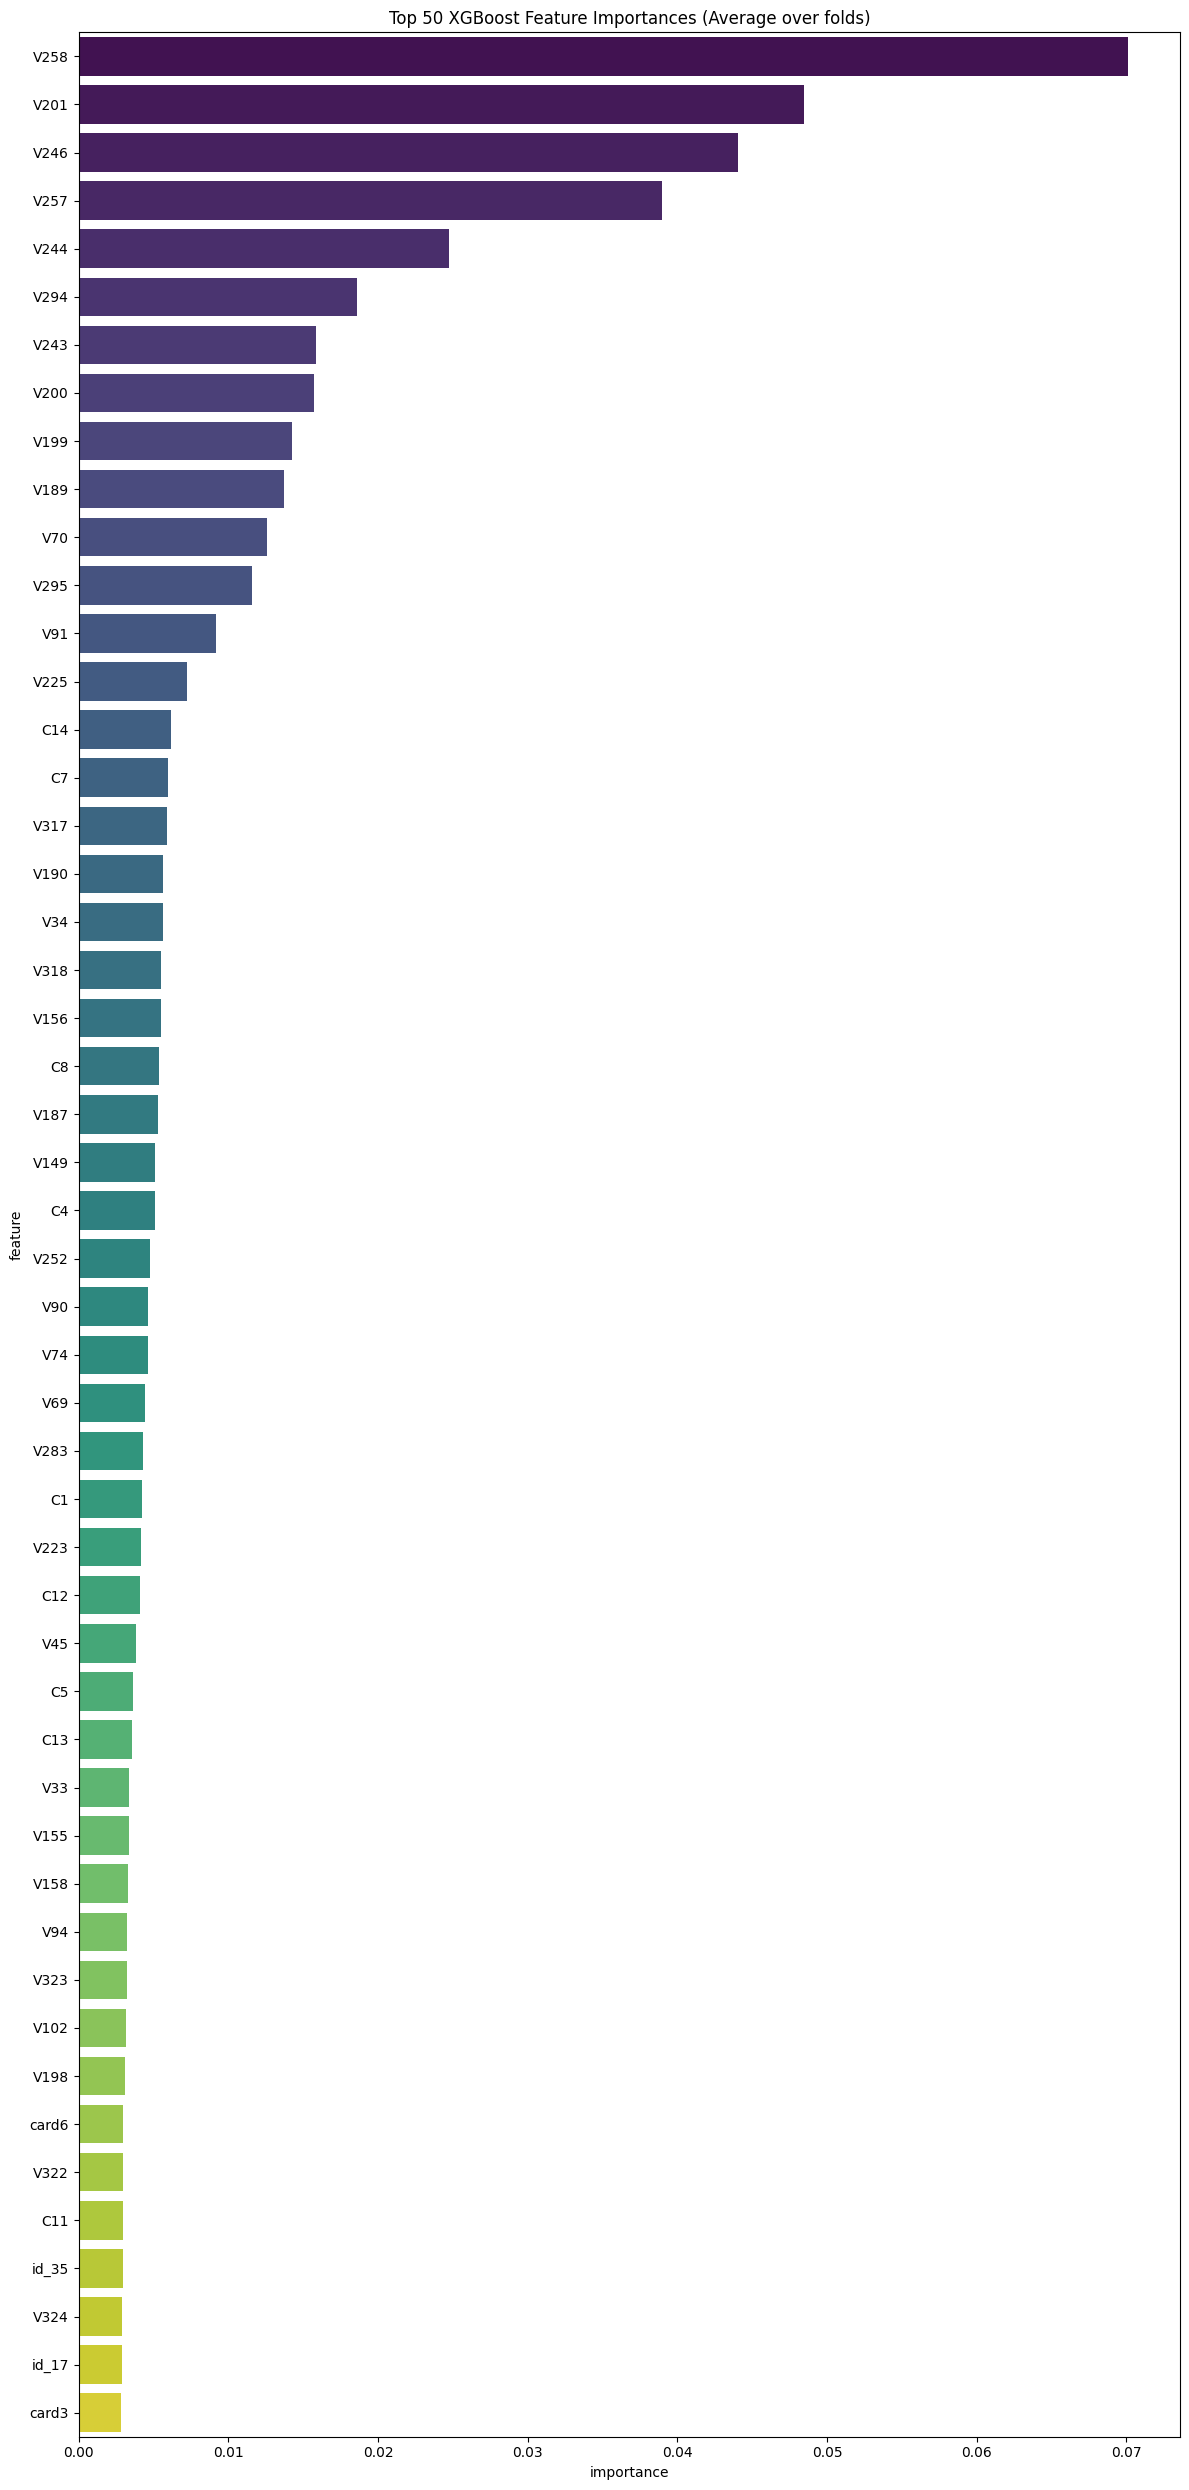

In [17]:
if pipeline.model is not None: # Check if model has been trained (at least the last fold's model)
    pipeline.plot_feature_importance(top_n=50)
else:
    print("Model not trained, skipping feature importance plot.")

### Generate and Save Predictions


Saving predictions to submission.csv...
Predictions successfully saved to submission.csv


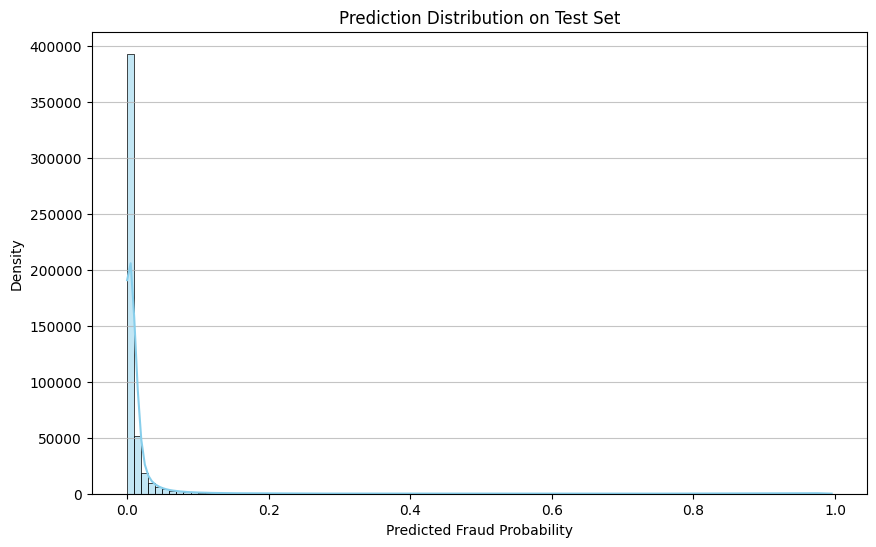

In [19]:
if pipeline.preds is not None:
    pipeline.save_predictions(
        sample_submission_path=SAMPLE_SUBMISSION_PATH,
        output_path=OUTPUT_SUBMISSION_PATH,
        plot_dist=True
    )
else:
    print("No predictions available to save. Ensure model training was successful.")

In [20]:
import pandas as pd

if pipeline.model is not None:
    model = pipeline.model  # Get the actual model object

    print("Attempting to extract feature importances...")

    # --- Method 1: Using .feature_importances_ (Common for LightGBM, XGBoost, Scikit-learn) ---
    try:
        print("\n--- Trying Method 1: .feature_importances_ ---")
        importances = model.feature_importances_

        # Try to get feature names automatically (adapt if needed)
        if hasattr(model, 'feature_name_'):
            feature_names = model.feature_name_()  # Standard for LightGBM
        elif hasattr(model, 'feature_names_in_'):
            feature_names = model.feature_names_in_  # Standard for Scikit-learn >= 1.0
        else:
            # --- IMPORTANT ---
            # If names aren't found, you MUST provide them manually.
            # They usually come from the columns of your training DataFrame (X_train.columns)
            # Ensure the order is EXACTLY the same as when the model was trained!
            print("Warning: Could not get feature names automatically.")
            print("You may need to provide 'feature_names' manually (e.g., from X_train.columns).")
            # As a placeholder, we'll use generic names:
            feature_names = [f'feature_{i}' for i in range(len(importances))]
            # Example: feature_names = list(your_training_dataframe.columns)

        # Create a DataFrame
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })

        # Sort by importance and print
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

        print("\n--- Top 50 Feature Importances (Method 1) ---")
        # .to_string() helps print more rows in many consoles
        print(feature_importance_df.head(50).to_string())

    except AttributeError:
        print("Method 1 Failed: Model doesn't have a '.feature_importances_' attribute.")

        # --- Method 2: Using XGBoost's .get_score() ---
        try:
            print("\n--- Trying Method 2: XGBoost .get_score() ---")
            # Default importance type is 'weight', 'gain' or 'cover' are often more informative
            importance_dict = model.get_booster().get_score(importance_type='gain')
            if not importance_dict: # Try weight if gain fails
                 importance_dict = model.get_booster().get_score(importance_type='weight')

            if importance_dict:
                feature_importance_df = pd.DataFrame(
                    list(importance_dict.items()),
                    columns=['Feature', 'Importance']
                ).sort_values(by='Importance', ascending=False).reset_index(drop=True)

                print("\n--- Top 50 Feature Importances (Method 2) ---")
                print(feature_importance_df.head(50).to_string())
            else:
                 print("Method 2 Failed: Could not get scores.")

        except AttributeError:
            print("Method 2 Failed: Model doesn't seem to be an XGBoost model or lacks .get_booster().")
        except Exception as e:
            print(f"Method 2 Failed with an error: {e}")

    except Exception as e:
        print(f"\nAn unexpected error occurred while getting feature importances: {e}")

else:
    print("Model not trained, skipping feature importance.")

Attempting to extract feature importances...

--- Trying Method 1: .feature_importances_ ---

--- Top 50 Feature Importances (Method 1) ---
   Feature  Importance
0     V258    0.065374
1     V201    0.050520
2     V246    0.046532
3     V257    0.036763
4     V244    0.033075
5     V294    0.017575
6     V243    0.015756
7     V200    0.013809
8      V70    0.013549
9     V199    0.013459
10    V295    0.011403
11     V91    0.010433
12    V225    0.008504
13    V189    0.008401
14   id_35    0.007373
15    V156    0.006728
16     C14    0.006517
17    V223    0.005941
18    V149    0.005599
19      C8    0.005340
20     V90    0.005307
21      C4    0.005166
22    V317    0.005128
23      C5    0.005120
24    V187    0.005001
25    V318    0.004878
26     V45    0.004511
27      C1    0.004487
28      C7    0.004463
29    V283    0.004408
30     C12    0.004060
31     V69    0.003984
32    V252    0.003956
33    V175    0.003946
34     C13    0.003627
35    V323    0.003626
36    V15

## Conclusion

## Conclusion

This notebook successfully implemented a comprehensive pipeline for the IEEE-CIS Fraud Detection challenge. Key steps included:

* **Data Ingestion and Preprocessing:** Efficiently loaded large datasets with optimized data types and merged transactional and identity information.
* **Extensive Feature Engineering:** Created a rich feature set by incorporating time-based features, parsing categorical data like email domains and device information, performing frequency and label encoding, generating interaction features, and deriving aggregated statistics.
* **Robust Model Training:** Utilized XGBoost with `GroupKFold` cross-validation, which is crucial for time-series-like data, achieving a cross-validation ROC AUC score of **0.9429**.
* **Insightful Feature Analysis:** The feature importance plot revealed that V-columns such as V258, V201, and V246 were among the most influential predictors in this model.
* **Prediction Generation:** Generated and saved submission-ready predictions, and visualized their distribution.

The pipeline demonstrates a strong approach to tackling complex fraud detection tasks, from initial data handling to model interpretation and prediction. The achieved AUC score indicates a good predictive performance. Further improvements could potentially be explored through more advanced feature engineering, hyperparameter optimization, or ensembling techniques.

The prediction distribution plot (generated during the `save_predictions` step) provides a visual confirmation of the model's output range and confidence.

In [2]:
# Code to display the prediction distribution plot again if needed
# (assuming 'pipeline' object and its 'preds' attribute are still available
# and SAMPLE_SUBMISSION_PATH is defined)

# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# if pipeline.preds is not None:
#     try:
#         submission_df_template = pd.read_csv(SAMPLE_SUBMISSION_PATH)
#         if pipeline.X_test.index.name == 'TransactionID':
#             pred_df = pd.DataFrame({'TransactionID': pipeline.X_test.index, 'isFraud': pipeline.preds})
#         else:
#             # Fallback if TransactionID is not the index (should be as per pipeline design)
#             # This might need adjustment based on the actual state of pipeline.X_test
#             # For instance, if TransactionID became a regular column:
#             # pred_df = pd.DataFrame({'TransactionID': pipeline.X_test['TransactionID'], 'isFraud': pipeline.preds})
#             # Or if the index is indeed TransactionID values but not named:
#             pred_df = pd.DataFrame({'TransactionID': pipeline.X_test.index, 'isFraud': pipeline.preds})


#         submission_df = submission_df_template[['TransactionID']].merge(pred_df, on='TransactionID', how='left')
#         if submission_df['isFraud'].isnull().any():
#             submission_df['isFraud'].fillna(0, inplace=True)

#         plt.figure(figsize=(10, 6))
#         sns.histplot(submission_df.isFraud, bins=100, kde=True, color="skyblue")
#         plt.title('Prediction Distribution on Test Set')
#         plt.xlabel('Predicted Fraud Probability')
#         plt.ylabel('Density')
#         plt.grid(axis='y', alpha=0.75)
#         plt.show()
#     except Exception as e:
#         print(f"Could not regenerate prediction distribution plot: {e}")
# else:
#     print("Predictions not available to plot distribution.")